### Library Import

In [1]:
import os
import pandas as pd
import numpy as np
import pickle

import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['text.color'] = 'white'#'#aaaaaa'
plt.rcParams.update({'text.color': "white",
                     'axes.labelcolor': "white"})

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorboard.plugins.hparams import api as hp
%load_ext tensorboard

import altair as alt
import seaborn as sns

import importlib

import warnings
warnings.filterwarnings('ignore')


In [2]:
# load in test_train_split custom function
from sklearn.metrics import confusion_matrix
import train
importlib.reload(train)
from train import test_train_split, train_test_model, run
import charts
importlib.reload(charts)
from charts import line_chart, plot_confusion_matrix_2, plot_roc, plot_metrics, plot_images, visualize

# Loading in Images

#### From pickeled files
For loading the images for the model simply run the the below code

In [42]:
# to load image files from pickles both train and test
dir = os.getcwd()

with open('{}/artifacts/{}'.format(dir, 'train_images_unrealEvenish_pkl.pkl'), 'rb') as pickle_file: #train_images_pkl_all.pkl
    train_data = pickle.load(pickle_file)

with open('{}/artifacts/{}'.format(dir, 'test_images_unrealUneven_pkl.pkl'), 'rb') as pickle_file: #test_images_pkl_even_ratio.pkl
    test_data = pickle.load(pickle_file)


Now that we have loaded the images we can split the training set in to training, development and test images. We have imported a function that we have created for this. 

In [122]:
#splitting in to test train split for the training data
train_images, train_labels, dev_images, dev_labels, test_images, test_labels = test_train_split(train_data)
print(np.array(train_images).shape)
print(np.array(train_labels).shape)

###############################
#Manual data augmentation flow#
###############################

#FLIPPING
augmented_train_images = []
augmented_train_labels = []
for i in range(len(train_images)):
    augmented_train_images.append(tf.image.flip_left_right(train_images[i]))
    augmented_train_labels.append(train_labels[i])
    # flipped = tf.image.flip_left_right(image, 0.4)
    # visualize(image, flipped)

train_images = tuple(list(train_images) + augmented_train_images)
train_labels = train_labels + tuple(augmented_train_labels)

#SATURATION
# saturated_train_images = []
# saturated_train_labels = []
# for i in range(len(train_images)):
#     saturated_train_images.append(tf.image.adjust_saturation(train_images[i], 2))
#     saturated_train_labels.append(train_labels[i])


# train_images = tuple(list(train_images) + saturated_train_images)
# train_labels = train_labels + tuple(saturated_train_labels)

# #BRIGHTNESS
# bright_train_images = []
# bright_train_labels = []
# for i in range(len(train_images)):
#     bright_train_images.append(tf.image.adjust_brightness(train_images[i], 0.4))
#     bright_train_labels.append(train_labels[i])

# train_images = tuple(list(train_images) + bright_train_images)
# train_labels = train_labels + tuple(bright_train_labels)

# #CONTRAST
# contrast_train_images = []
# contrast_train_labels = []
# for i in range(len(train_images)):
#     contrast_train_images.append(tf.image.adjust_contrast(train_images[i], 0.4))
#     contrast_train_labels.append(train_labels[i])

# train_images = tuple(list(train_images) + contrast_train_images)
# train_labels = train_labels + tuple(contrast_train_labels)



#normalize the images
train_images, dev_images, test_images = np.array(train_images) / 255.0, \
                                        np.array(dev_images) / 255.0, \
                                        np.array(test_images) / 255.0

# print(train_images.shape)
# print(train_labels.shape)

train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

input_shape = train_images.shape[1:]
print(input_shape)
print(train_images.shape)
print(train_labels.shape)


(1030, 100, 195, 3)
(1030, 1)


In [144]:
hold_out_images, hold_out_labels = zip(*test_data)

#normalize the images
hold_out_images = np.array(hold_out_images) / 255.0

augmented_hold_out_images = []
augmented_hold_out_labels = []
for i in range(len(hold_out_images)):
    augmented_hold_out_images.append(tf.image.flip_left_right(hold_out_images[i]))
    augmented_hold_out_labels.append(hold_out_labels[i])

hold_out_images = tuple(list(hold_out_images) + augmented_hold_out_images)
hold_out_labels = hold_out_labels + tuple(augmented_hold_out_labels)

hold_out_images = tf.convert_to_tensor(hold_out_images , dtype=tf.float32)
# input_shape = hold_out_images.shape[1:]

# plot_images(hold_out_images, hold_out_labels)

(140, 100, 196, 3)
(280, 100, 196, 3)
280
([1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0

# Hyperparameter Tuning

In [45]:
%reload_ext tensorboard
#! rm -rf ./logs/

In [66]:
session_num = 0
epochs = 50
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16,32,64]))#, 64])) #8, 16, 16,32,
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.4, 0.5))
# dropout_rate = 0.2
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam','RMSprop','Nadam',]))#,'adam', 'Nadam'])) #'sgd','Adagrad','RMSprop',,'Nadam','Nadam'

params = []
losses = []
accuracies = []
f1_scores = []
precisions = []
recalls = []
aucs = []
cms = []
units = []
dropouts = []
optimizers = []
histories = []
modelz = []
predictions = []

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
        hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        units.append(num_units)
        dropouts.append(dropout_rate)
        optimizers.append(optimizer)
        model = run('logs/hparam_tuning/' + run_name, hparams, epochs, input_shape,train_images,train_labels,test_images, test_labels,
                HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER, predictions,
                params, losses, accuracies, f1_scores, precisions, recalls, cms, aucs,
                units, dropouts, optimizers, histories, augmentModel=True)
        modelz.append(model)
        session_num += 1

--- Starting trial: run-0
{'num_units': 16, 'dropout': 0.4, 'optimizer': 'Nadam'}
Epoch 1/50
65/65 [==============================] - 35s 498ms/step - loss: 1.5977 - accuracy: 0.4388 - f1_m: 0.2869 - precision_m: 0.3485 - recall_m: 0.2677
Epoch 2/50
65/65 [==============================] - 33s 503ms/step - loss: 1.1151 - accuracy: 0.6136 - f1_m: 0.2895 - precision_m: 0.2682 - recall_m: 0.3358
Epoch 3/50
65/65 [==============================] - 33s 506ms/step - loss: 0.8745 - accuracy: 0.7481 - f1_m: 0.4646 - precision_m: 0.3834 - recall_m: 0.6138
Epoch 4/50
65/65 [==============================] - 33s 505ms/step - loss: 0.7782 - accuracy: 0.7680 - f1_m: 0.4686 - precision_m: 0.3934 - recall_m: 0.6036
Epoch 5/50
65/65 [==============================] - 32s 498ms/step - loss: 0.7470 - accuracy: 0.7820 - f1_m: 0.4710 - precision_m: 0.3928 - recall_m: 0.6101
Epoch 6/50
65/65 [==============================] - 32s 493ms/step - loss: 0.8124 - accuracy: 0.7063 - f1_m: 0.4823 - precision_m: 0.

In [67]:
# epoch20dropout23optimize3 = modelz
epoch50dropout45optimize3 = modelz

In [68]:
#dataframe assembly for model comparison
#integrate confusion matrices as well

modelDf = pd.DataFrame(list(zip(units, dropouts, optimizers, losses, accuracies, f1_scores, precisions, recalls, cms)),#aucs, 
               columns =['units', 'dropouts', 'optimizers', 'losses', 'accuracies', 'f1_scores', 'precisions', 'recalls', 'cms'])#'aucs',

# epoch20dropout23optimize3Df = modelDf
# epoch20dropout23optimize3Histories = histories
epoch50dropout45optimize3Df = modelDf
epoch50dropout45optimize3Histories = histories

modelDf

,units,dropouts,optimizers,losses,accuracies,f1_scores,precisions,recalls,cms
0,16,0.4,Nadam,4.438607e-03,1.000000,0.725568,0.59375,1.0,"[[65, 0], [0, 64]]"
1,16,0.4,RMSprop,1.313879e-02,0.992248,0.725568,0.59375,1.0,"[[65, 0], [1, 63]]"
2,16,0.4,adam,1.121060e-01,0.968992,0.725568,0.59375,1.0,"[[61, 4], [0, 64]]"
3,16,0.5,Nadam,1.942038e-02,0.992248,0.725568,0.59375,1.0,"[[65, 0], [1, 63]]"
4,16,0.5,RMSprop,9.699044e-02,0.992248,0.725568,0.59375,1.0,"[[65, 0], [1, 63]]"
5,16,0.5,adam,8.282491e-03,0.992248,0.725568,0.59375,1.0,"[[65, 0], [1, 63]]"
6,32,0.4,Nadam,1.377893e-01,0.984496,0.725568,0.59375,1.0,"[[65, 0], [2, 62]]"
7,32,0.4,RMSprop,4.722096e-07,1.000000,0.725568,0.59375,1.0,"[[65, 0], [0, 64]]"
8,32,0.4,adam,3.620058e-02,0.992248,0.725568,0.59375,1.0,"[[65, 0], [1, 63]]"
9,32,0.5,Nadam,1.883154e-03,1.000000,0.725568,0.59375,1.0,"[[65, 0], [0, 64]]"


In [69]:
#Best so far

# 70 TN / 13 FN / 2 FP / 57 TP -- adam / 32 units / 0.2 dropout / 10 epochs
# 54 TN / 11 FN / 18 FP / 59 TP -- Nadam / 32 units / 0.3 dropout / 10 epochs
# 35 TN / 12 FN / 37 FP / 58 TP -- adam / 16 units / 0.1 dropout / 25 epochs
# 40 TN / 17 FN / 32 FP / 53 TP -- RMSprop / 16 units / 0.5 dropout / 25 epochs

In [70]:
# model = modelz[8]

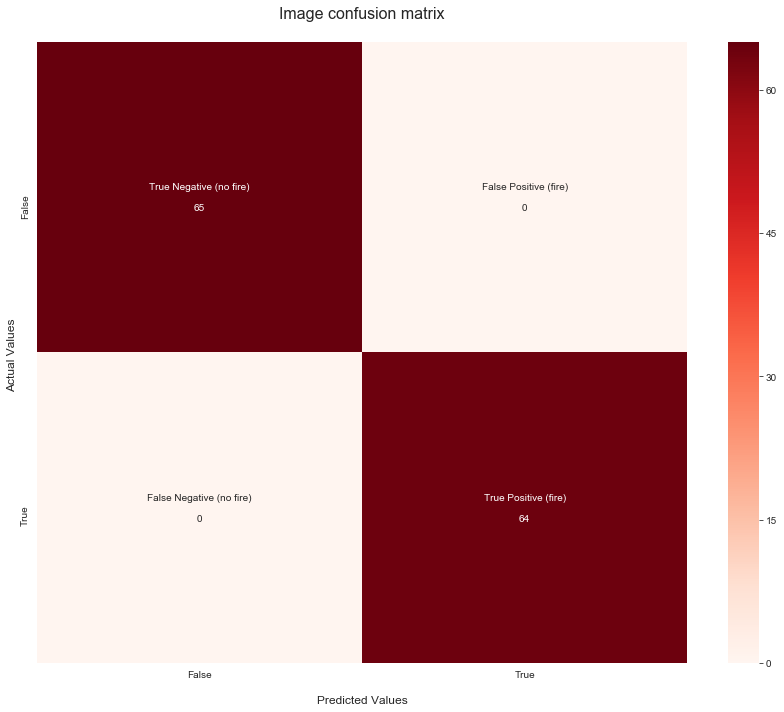

In [71]:

modelDf['cms'].values[0]

plot_confusion_matrix_2(modelDf['cms'].values[0],normalize=False)

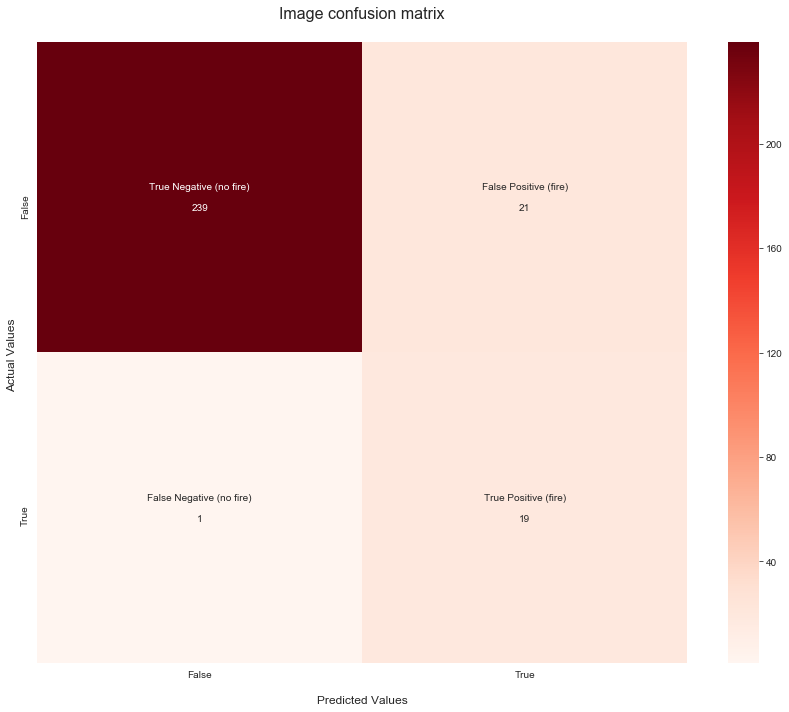

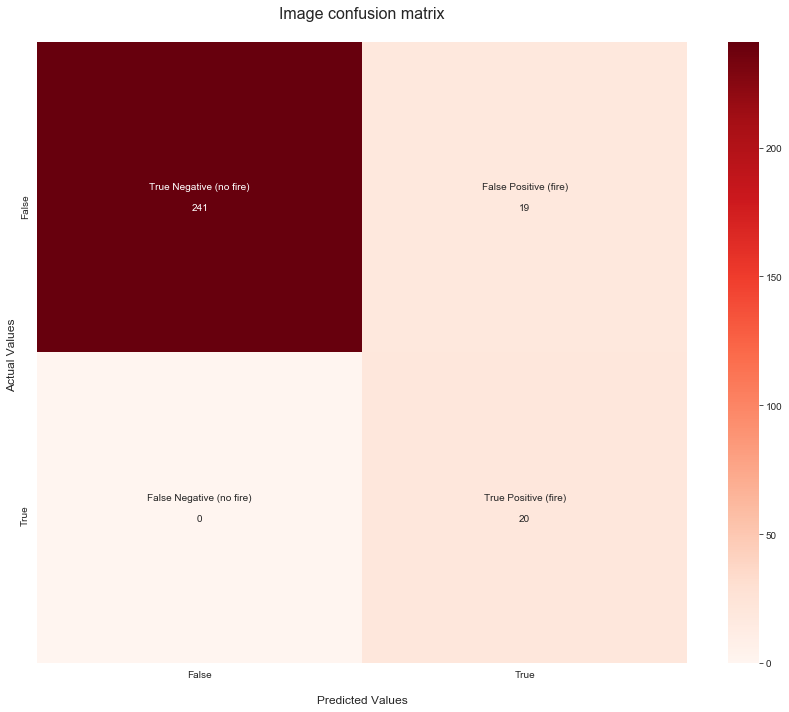

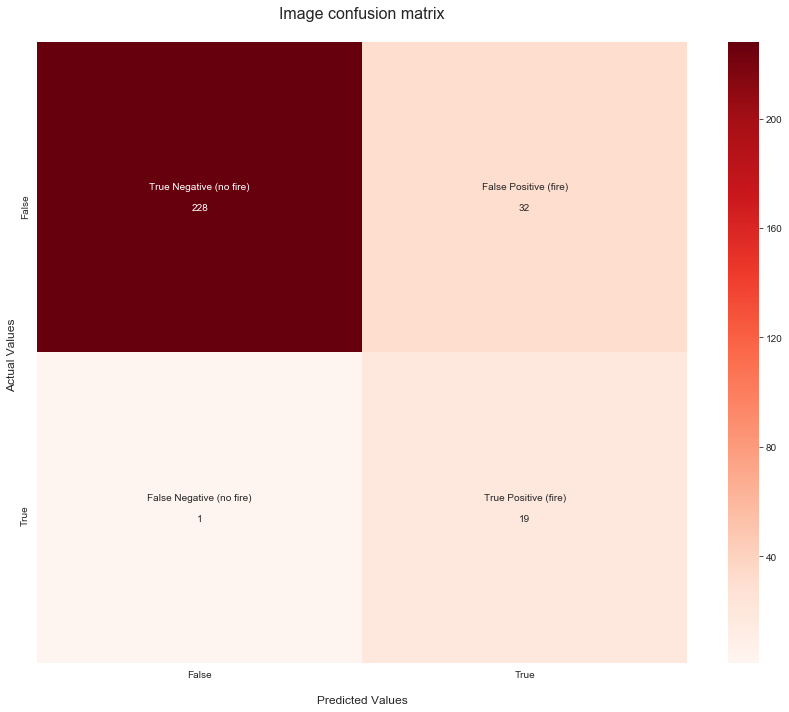

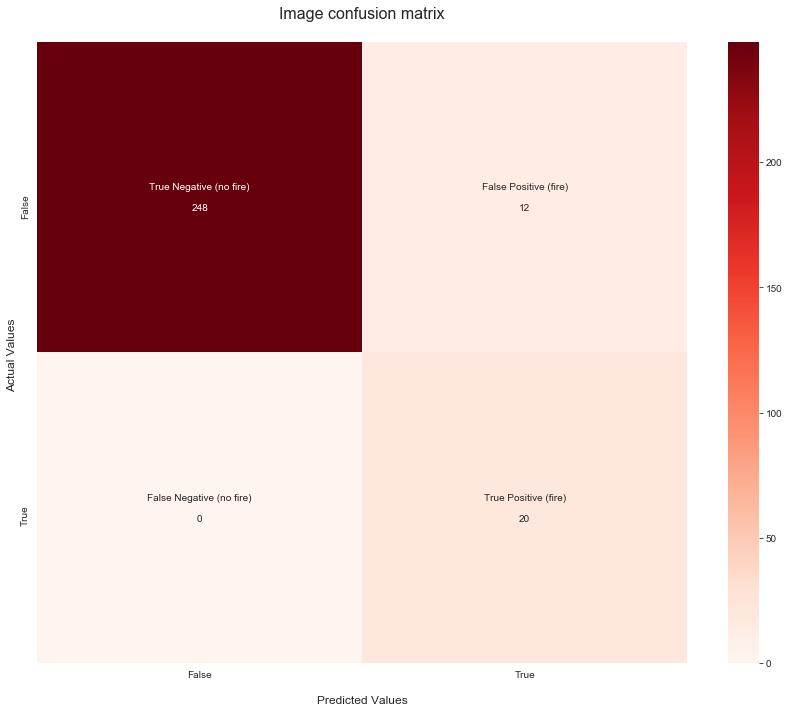

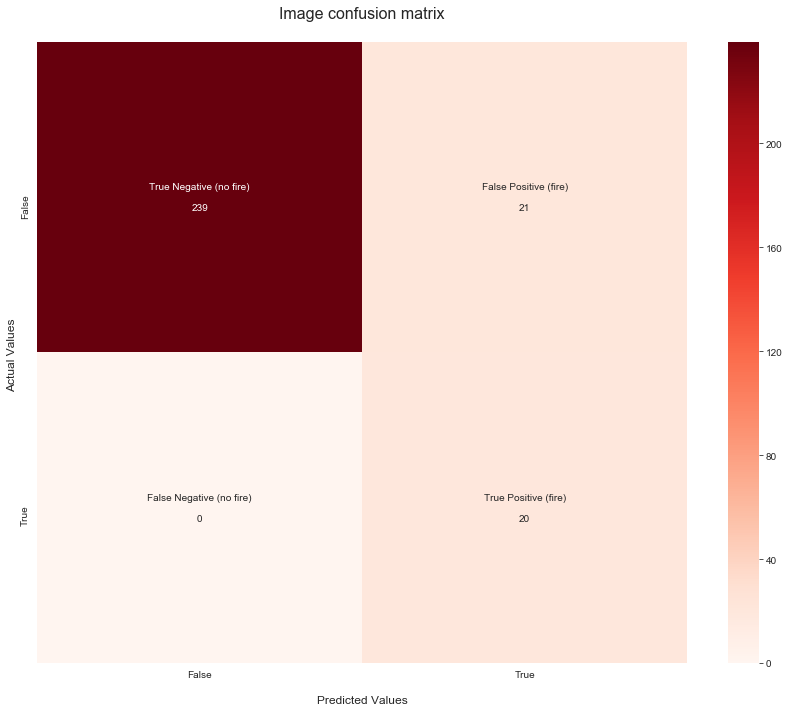

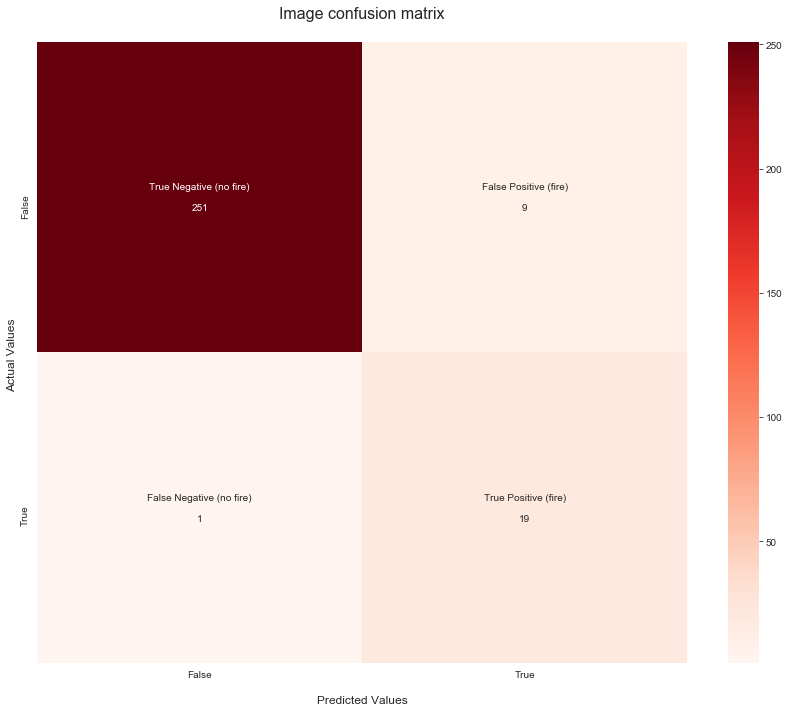

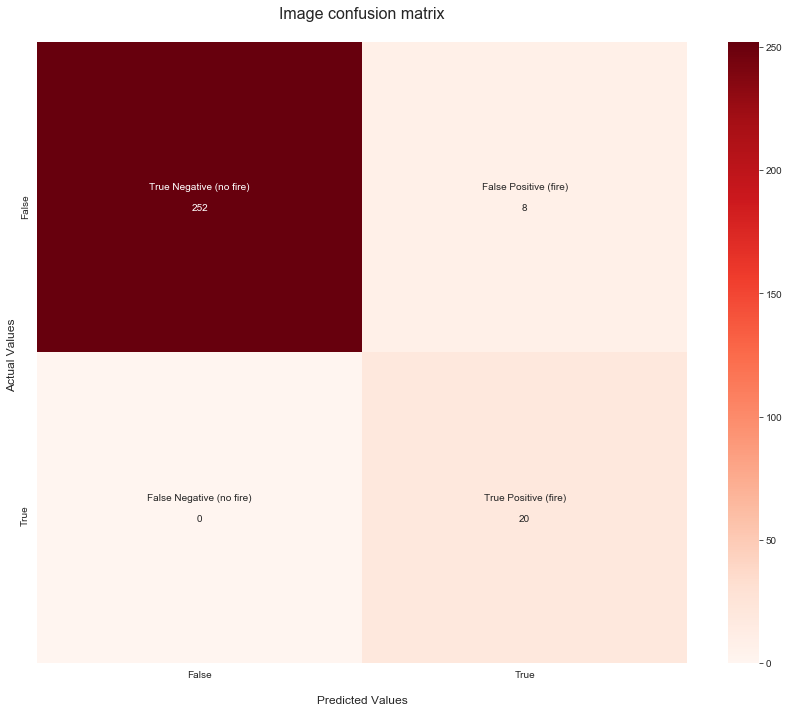

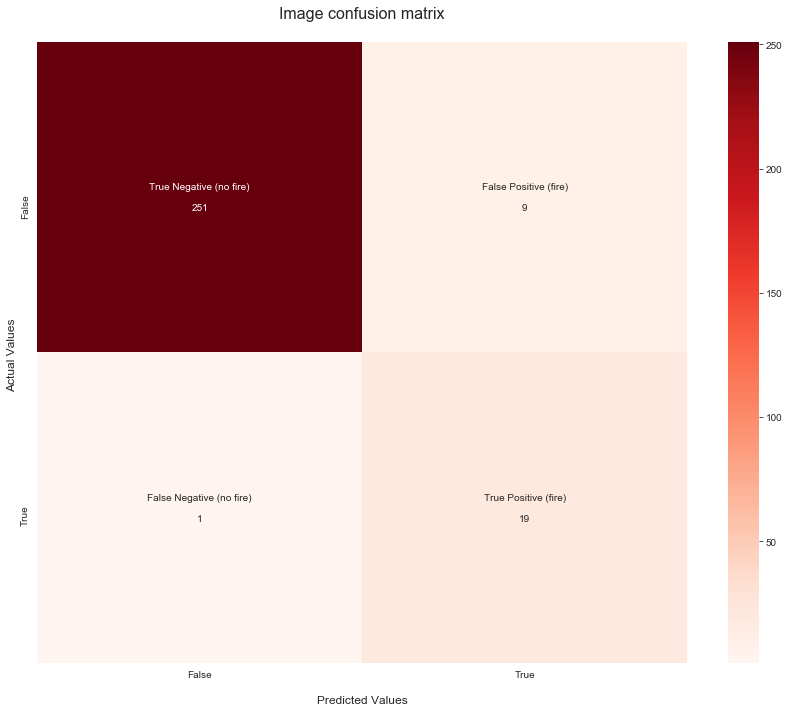

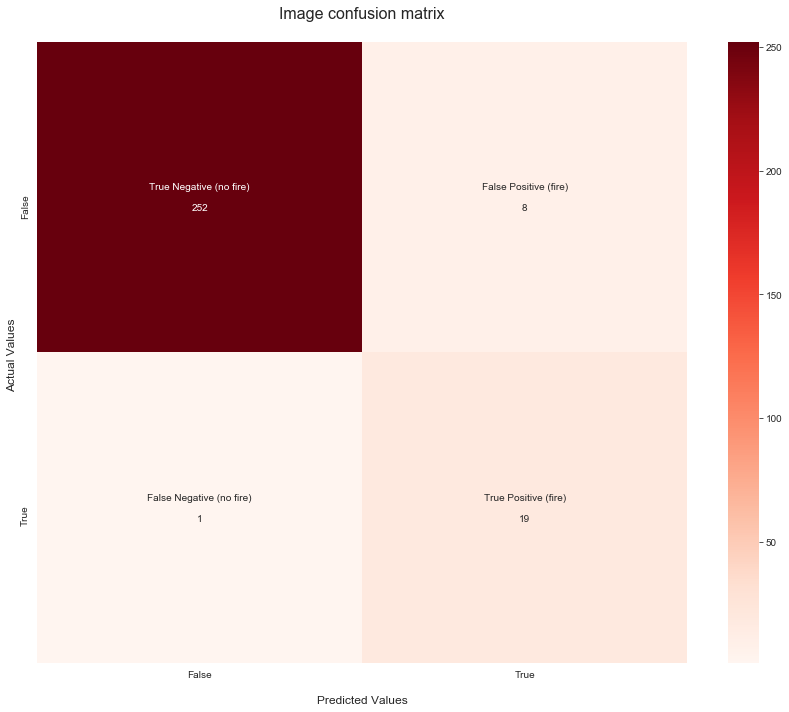

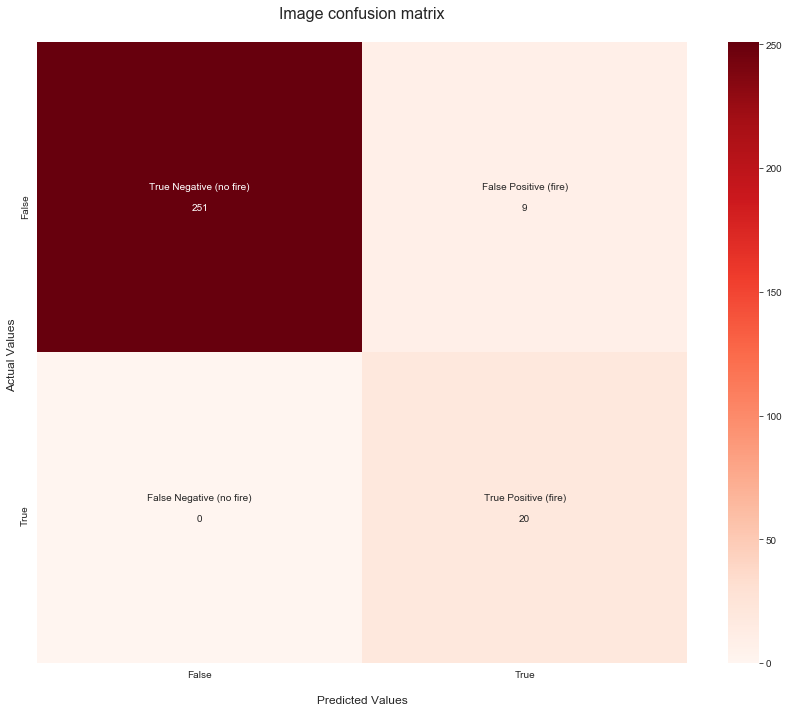

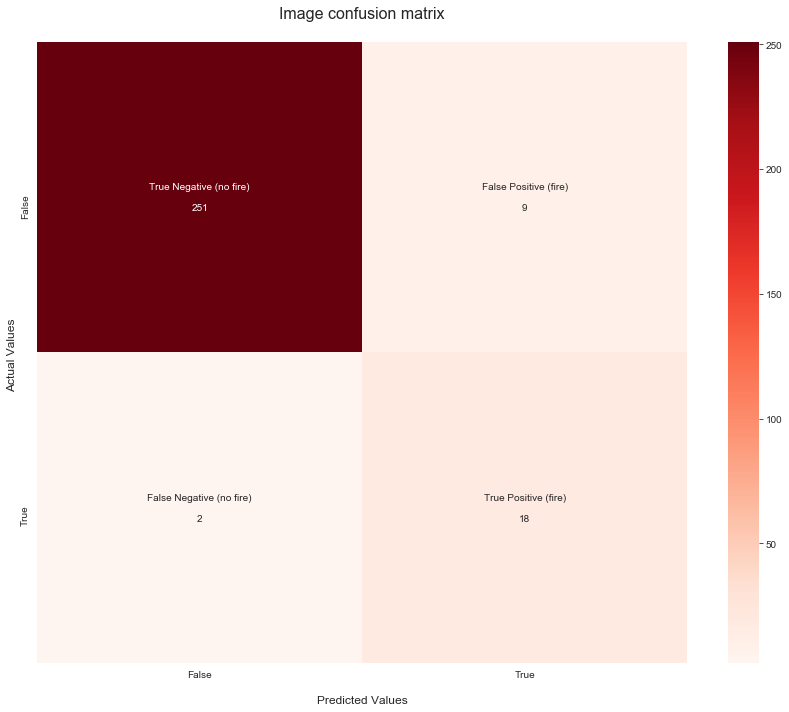

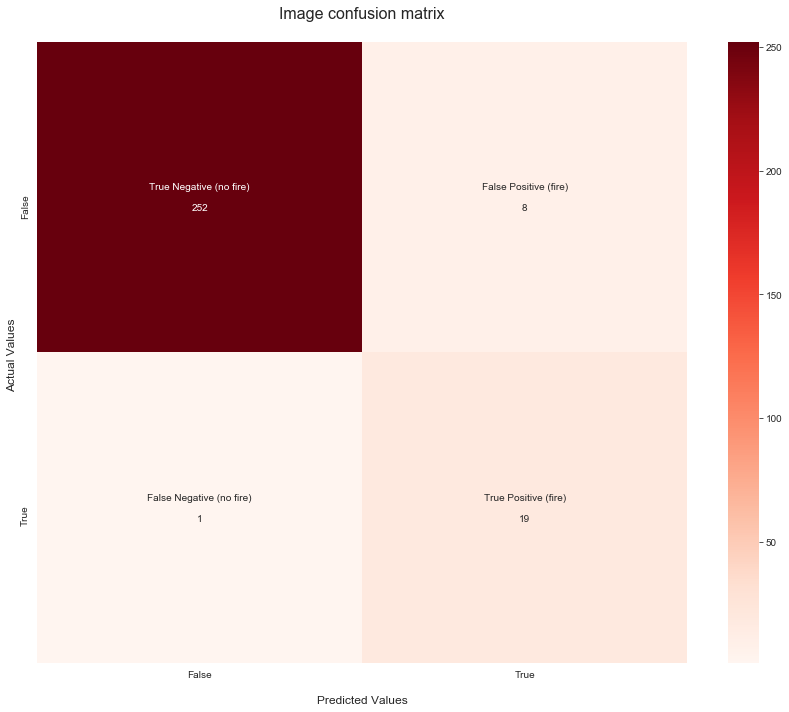

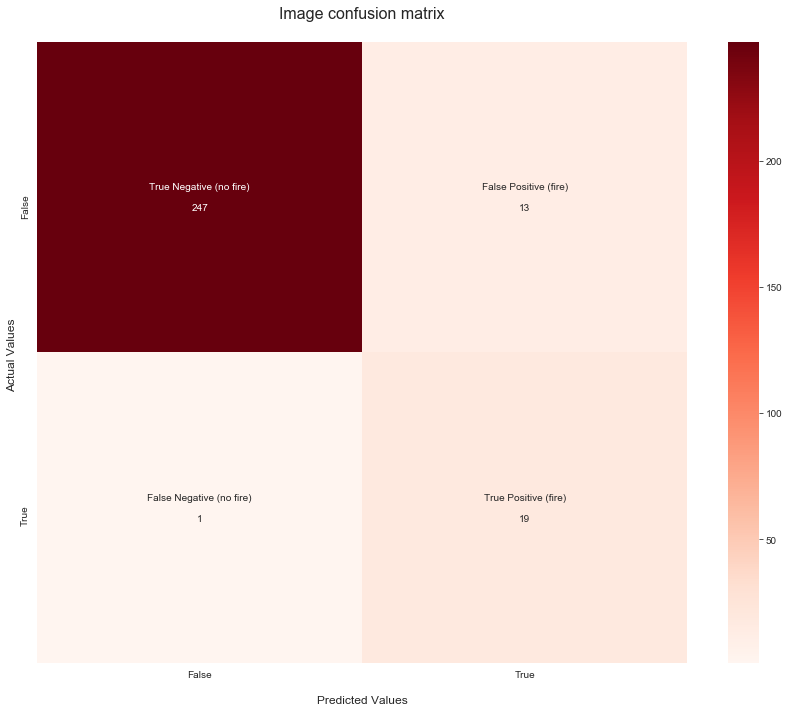

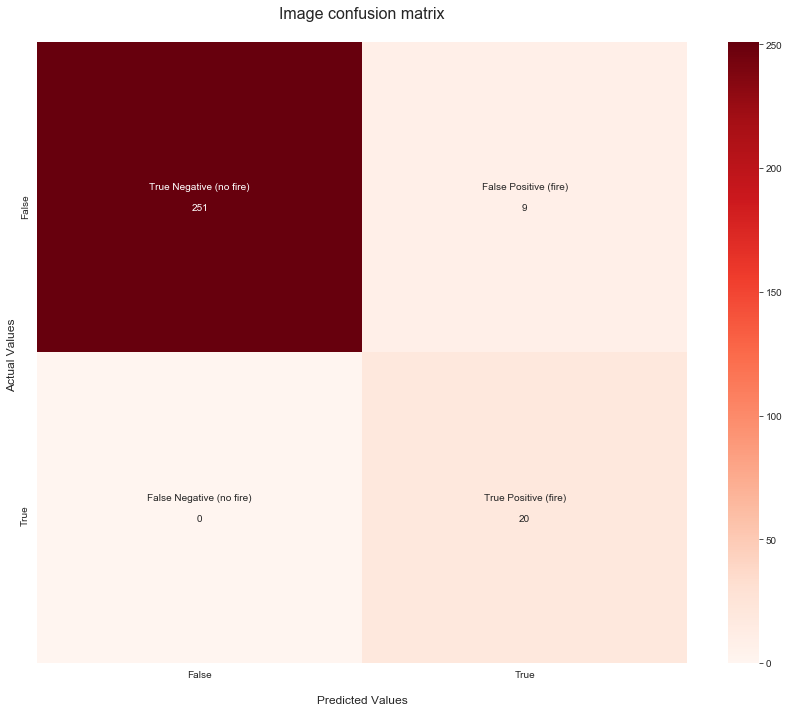

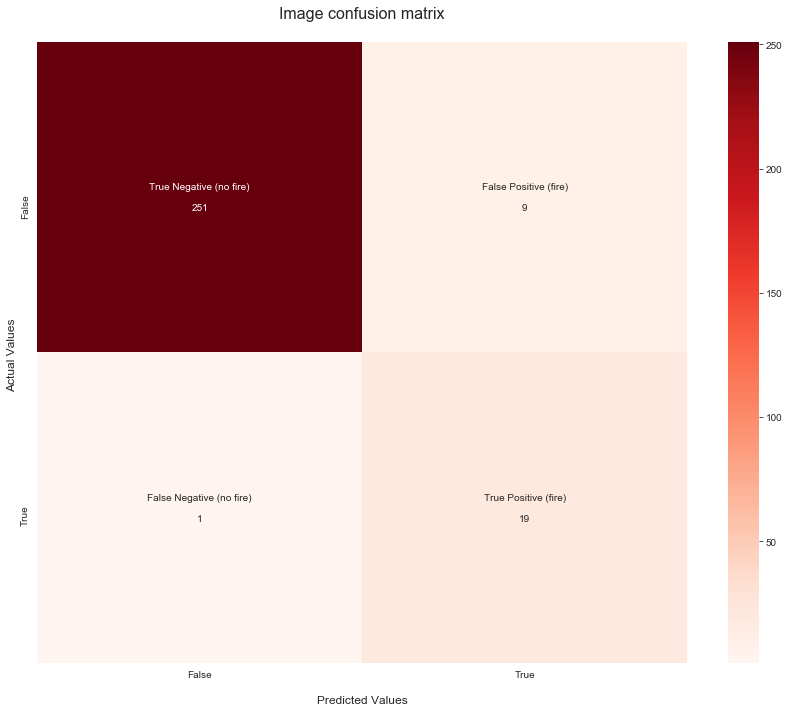

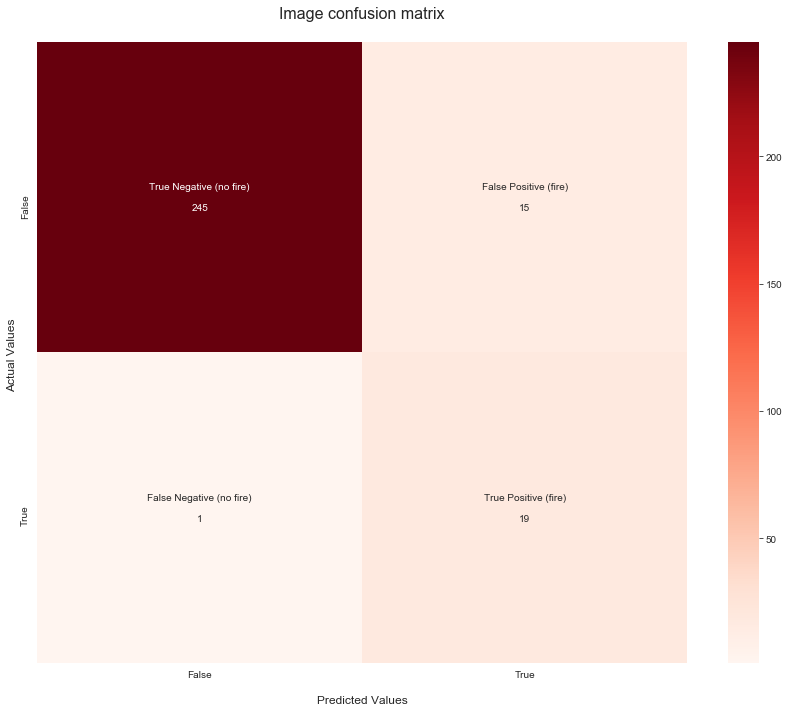

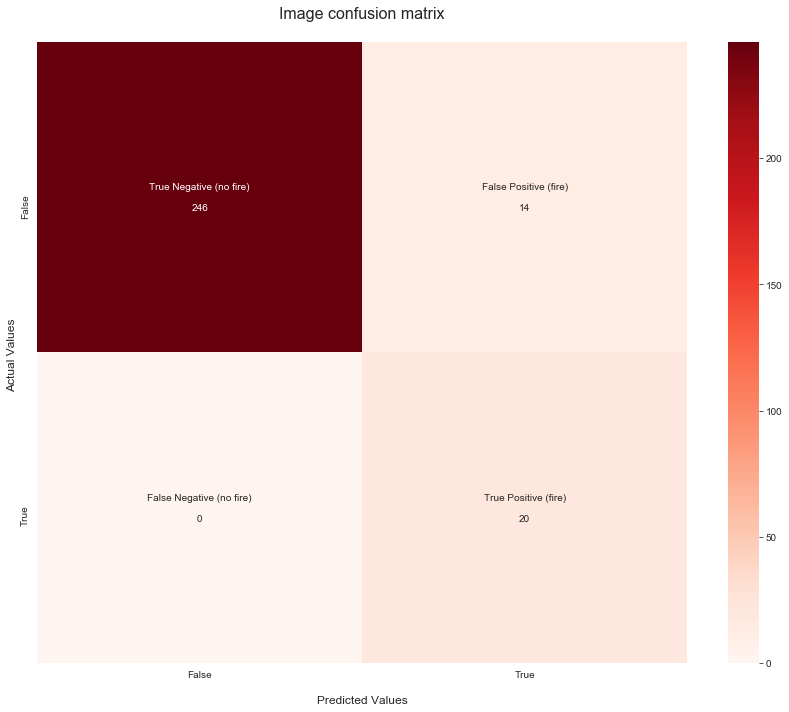

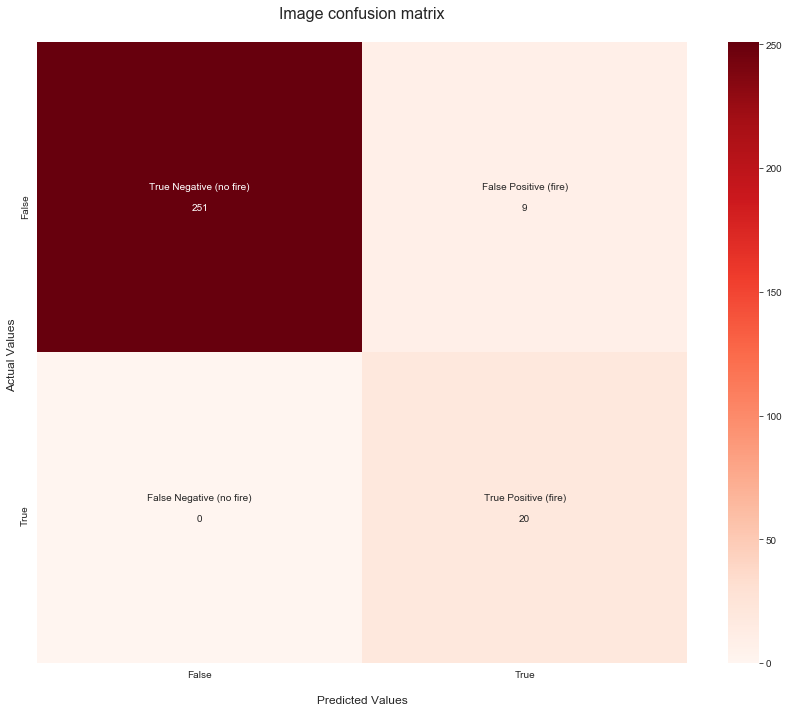

In [89]:
for model in modelz:
    predictions2 = model.predict(x=hold_out_images, steps=len(hold_out_images), verbose=0)
    cm2 = confusion_matrix(y_true=hold_out_labels, y_pred=np.argmax(predictions2, axis=-1))
    plot_confusion_matrix_2(cm2,normalize=False)

In [148]:
with open('{}/artifacts/{}'.format(dir, 'real_images_test.pkl'), 'rb') as pickle_file: #train_images_pkl_all.pkl
    real_test_data = pickle.load(pickle_file)

# with open('{}/artifacts/{}'.format(dir, 'test_images_pkl_uneven_w_drone.pkl'), 'rb') as pickle_file: #train_images_pkl_all.pkl
#     real_test_data = pickle.load(pickle_file)

In [149]:
hold_out_images, hold_out_labels = zip(*real_test_data)

#normalize the images
hold_out_images = np.array(hold_out_images) / 255.0
print(hold_out_images.shape)

augmented_hold_out_images = []
augmented_hold_out_labels = []
for i in range(len(hold_out_images)):
    augmented_hold_out_images.append(tf.image.flip_left_right(hold_out_images[i]))
    augmented_hold_out_labels.append(hold_out_labels[i])

hold_out_images = tuple(list(hold_out_images) + augmented_hold_out_images)
hold_out_labels = hold_out_labels + tuple(augmented_hold_out_labels)

hold_out_images = tf.convert_to_tensor(hold_out_images , dtype=tf.float32)
# input_shape = hold_out_images.shape[1:]

print(hold_out_images.shape)
print(len(hold_out_labels))
print(hold_out_labels)

# plot_images(hold_out_images, hold_out_labels)

(950, 100, 173, 3)
(1900, 100, 173, 3)
1900
tf.Tensor(
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]], shape=(1900, 1), dtype=float32)


In [141]:
# model = modelz[0]
# predictions2 = model.predict(x=hold_out_images, steps=len(hold_out_images), verbose=0)

In [150]:
for model in modelz:
    predictions2 = model.predict(x=hold_out_images, steps=len(hold_out_images), verbose=0)
    cm2 = confusion_matrix(y_true=hold_out_labels, y_pred=np.argmax(predictions2, axis=-1))
    plot_confusion_matrix_2(cm2,normalize=False)

InvalidArgumentError:  Matrix size-incompatible: In[0]: [1,32256], In[1]: [36864,16]
	 [[node sequential_81/dense_80/Relu (defined at <ipython-input-76-b347443aa0e5>:2) ]] [Op:__inference_predict_function_682429]

Function call stack:
predict_function


In [62]:
# history_df = pd.DataFrame(histories[0].history).reset_index()
history_df = histories[0]

In [32]:
model.save("artifacts/model_20211201.h5")

In [63]:
line_chart(history_df)

KeyError: "The following 'value_vars' are not present in the DataFrame: ['auc', 'precision', 'recall']"

In [ ]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

# for i in range(len(list(modelDf.optimizers))):
#     cls = modelDf.iloc[i,2]
#     plot_confusion_matrix_2(modelDf[modelDf['optimizers']==cls]['cms'][i])
#     ax.title.set_text(type(cls).__name__)
# plt.tight_layout()  
# plt.show()

In [147]:
# train_predictions_baseline = model.predict(train_images)
# test_predictions_baseline = model.predict(test_images)
plot_roc("Train Baseline", train_labels, predictions[0], color=colors[0])
plot_roc("Test Baseline", hold_out_labels, predictions2, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

ValueError: Found input variables with inconsistent numbers of samples: [2060, 129]

In [ ]:
plot_metrics(history)